# unsafe_mfdataset demo

`unsafe_mfdataset()` constructs a virtual file for a large collection, without having to open all of the individual files. It makes some assumptions that could be invalid in some situations

In [1]:
%matplotlib inline
from coecms.bigdata import unsafe_mfdataset
import pandas
import xarray
from pandas.tseries.offsets import *

## ERA-Interim

Era-Interim has one file per month, with names like

    /g/data1/ub4/erai/netcdf/3hr/atmos/oper_fc_sfc/v01/tas/tas_3hrs_ERAI_historical_fc-sfc_20040101_20040131.nc
    
Each file contains 3 hourly data, from 0300 on the first of the month, to 0000 on the first of the following month

For convenience I've made a function that finds the file name associated with a given date - I need it to calculate both the start and end day of the given month

In [81]:
def erai_path(date):
    date = date - 3*Hour()
    mstart = (date - MonthEnd() + Day()).strftime('%Y%m%d')
    mend = (date + MonthBegin() - Day()).strftime('%Y%m%d')
    return f'/g/data1/ub4/erai/netcdf/3hr/atmos/oper_fc_sfc/v01/tas/tas_3hrs_ERAI_historical_fc-sfc_{mstart}_{mend}.nc'

In [82]:
# Check the paths are printed correctly
sample = '/g/data1/ub4/erai/netcdf/3hr/atmos/oper_fc_sfc/v01/tas/tas_3hrs_ERAI_historical_fc-sfc_20040101_20040131.nc'

assert erai_path(pandas.to_datetime('20040101T0300')) == sample
assert erai_path(pandas.to_datetime('20040103T1800')) == sample
assert erai_path(pandas.to_datetime('20040201T0000')) == sample

With this function I can work out the files needed for a specific time period. First I get a sequence of monthly dates using pandas, then apply `erai_path()` to each date in turn

In [4]:
dates = pandas.date_range('19810101', '20171231', freq='MS')
paths = [erai_path(d) for d in dates]

The list of files can be passed to `unsafe_mfdataset()`

In [5]:
ds = unsafe_mfdataset(paths)
ds

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480, time: 108112)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 87.0 86.25 85.5 84.75 84.0 ...
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 -177.0 -176.2 -175.5 ...
  * time     (time) datetime64[ns] 1981-01-01T03:00:00 1981-01-01T06:00:00 ...
Data variables:
    tas      (time, lat, lon) float32 dask.array<shape=(108112, 241, 480), chunksize=(248, 241, 480)>
Attributes:
    CDI:          Climate Data Interface version 1.6.9 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Thu Sep  3 10:14:33 2015: ncks -O --md5_wrt_att -v tas 2T_1...
    CDO:          Climate Data Operators version 1.6.9 (http://mpimet.mpg.de/...
    title:        ERA-Interim 2 metre temperature [K] forecast on surface (gl...
    institution:  ARCCSS ARC Centre of Excellence for Climate System Science ...
    source:       Original grib files obtained from http://apps.ecmwf.int/dat...
    references:   Please acknowledge both 

[########################################] | 100% Completed | 22.9s


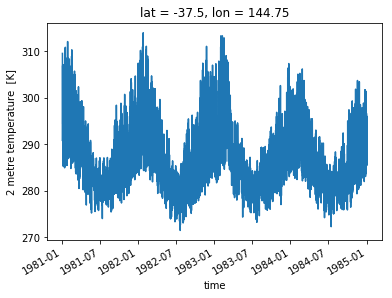

In [84]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    da = ds.tas.sel(lat=-37.8136, lon=144.9631, method='nearest').sel(time=slice(None, '19850101'))
    da.plot()

## MUR

MUR data has one file per day, with OpenDAP urls like

    https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2002/152/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
    
First a function to get the date of a file:

In [2]:
def mur_path(date):
    yyyy = date.year
    doy = "%03d"%date.dayofyear
    yyyymmdd = date.strftime('%Y%m%d')
    return f'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/{yyyy}/{doy}/{yyyymmdd}090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'

In [3]:
mur_path(pandas.to_datetime('20020601'))

'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2002/152/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'

This dataset is really high resolution, so we'll use dask chunks in the lat and lon dimensions, so we only download what we need.

For whatever reason the default `'netCDF4'` engine has trouble with this OpenDAP server, so I'm using `'pydap'`.

In [4]:
%%time

paths = [mur_path(d) for d in pandas.date_range('20020601','20020701')]
ds = unsafe_mfdataset(paths, engine='pydap', chunks={'lat': 1000, 'lon': 1000})
ds.analysed_sst

CPU times: user 4.15 s, sys: 128 ms, total: 4.28 s
Wall time: 2min 45s


CPU times: user 13.4 s, sys: 15.7 s, total: 29.2 s
Wall time: 48.7 s


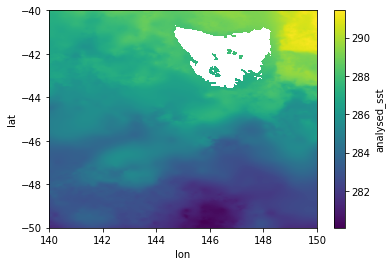

In [34]:
%%time

ds.analysed_sst.sel(lat=slice(-50,-40), lon=slice(140,150)).mean('time').plot()

In [37]:
%%time

xarray.open_mfdataset(paths, engine='pydap', chunks={'lat': 1000, 'lon': 1000})

CPU times: user 8.6 s, sys: 315 ms, total: 8.92 s
Wall time: 7min 11s


<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 31)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2002-07-01T09:00:00
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<shape=(31, 17999, 36000), chunksize=(1, 1000, 1000)>
    analysis_error    (time, lat, lon) float32 dask.array<shape=(31, 17999, 36000), chunksize=(1, 1000, 1000)>
    mask              (time, lat, lon) float32 dask.array<shape=(31, 17999, 36000), chunksize=(1, 1000, 1000)>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<shape=(31, 17999, 36000), chunksize=(1, 1000, 1000)>
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references: 

In [39]:
%%time
from pydap.client import open_url

for p in paths:
    open_url(p)

CPU times: user 2.26 s, sys: 71.7 ms, total: 2.33 s
Wall time: 1min 47s


In [45]:
%%time

xarray.open_dataset(paths[0], engine='pydap', decode_cf = False, drop_variables=['lat','lon'])

CPU times: user 135 ms, sys: 973 µs, total: 136 ms
Wall time: 5.18 s


<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 1)
Coordinates:
  * time              (time) int32 675766800
Dimensions without coordinates: lat, lon
Data variables:
    analysed_sst      (time, lat, lon) int16 ...
    analysis_error    (time, lat, lon) int16 ...
    mask              (time, lat, lon) int16 ...
    sea_ice_fraction  (time, lat, lon) int16 ...
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    comment:                    MUR = \"Multi-scale Ultra-high Reolution\
    license:                    These data are available free of charge under...
    id:                         MUR-JPL-L4-GLOB-